In [5]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Data set de kaggle (Pokemon)
path = kagglehub.dataset_download("abcsds/pokemon")

100%|██████████████████████████████████████████████████████████████████████████████| 14.9k/14.9k [00:00<00:00, 4.70MB/s]

Extracting files...


In [3]:
#Leer el dataset
df = pd.read_csv(f"{path}/Pokemon.csv")

In [4]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [6]:
#Para este entrenamiento voy a buscar si el pokemon es pseudo-legendario o no, por lo que voy a crear una nueva columna con esta información
pseudo_legendary_total = 600
df['is_pseudo_legendary'] = (
    (df['Total'] == pseudo_legendary_total) & 
    (df['Legendary'] == False)
) 

#La siguiente prediccion es para ver el top 15 de pokemon en base a sus stats
top_n = 15
top_pokemon = df.nlargest(top_n, 'Total')
df['is_top15'] = df.index.isin(top_pokemon.index)

# Crear variable objetivo: 0=Normal, 1=Top15, 2=Pseudo-Legendario, 3=Legendario
def categorize_pokemon(row):
    if row['is_top15']:
        return 1  # Top 15 (tiene prioridad sobre todas las demás)
    elif row['Legendary']:
        return 3  # Legendario
    elif row['is_pseudo_legendary']:
        return 2  # Pseudo-Legendario
    else:
        return 0  # Normal

df['category'] = df.apply(categorize_pokemon, axis=1)

# Mapeo de categorías
category_names = {
    0: 'Normal',
    1: 'Top 15 Stats',
    2: 'Pseudo-Legendario',
    3: 'Legendario'
}

df['category_name'] = df['category'].map(category_names)

In [7]:
le_type1 = LabelEncoder()
df['Type1_encoded'] = le_type1.fit_transform(df['Type 1'])

# Type 2 puede tener valores nulos
df['Type 2'] = df['Type 2'].fillna('None')
le_type2 = LabelEncoder()
df['Type2_encoded'] = le_type2.fit_transform(df['Type 2'])

# Características para el modelo
features = [
    'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
    'Generation', 'Type1_encoded', 'Type2_encoded', 'Total'
]

In [8]:
X = df[features]
y = df['category']

Seccion de entrenamiento

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Seccion de escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, 
                                           class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test_scaled)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"  Accuracy en test: {accuracy:.4f}")
    print(f"  Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Entrenando Random Forest...
  Accuracy en test: 0.9750
  Cross-validation: 0.9484 (+/- 0.0168)

Entrenando Gradient Boosting...
  Accuracy en test: 0.9750
  Cross-validation: 0.9672 (+/- 0.0031)


In [12]:
#Seleccionamos el mejor modelo
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"\nMejor modelo: {best_model_name} con accuracy {results[best_model_name]['accuracy']:.4f}")


Mejor modelo: Random Forest con accuracy 0.9750


In [13]:
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
else:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    base_model = GradientBoostingClassifier(random_state=42)

In [14]:
#Grid Search para optimización de hiperparámetros
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [15]:
#Optimizando modelo con gridsearch
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test_scaled)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

In [ ]:
import os

# Crear carpeta 'models' si no existe, en mi caso la carpeta no existe
os.makedirs('models', exist_ok=True)

# Guardar modelo y componentes en la carpeta local
joblib.dump(optimized_model, 'models/pokemon_classifier_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le_type1, 'models/label_encoder_type1.pkl')
joblib.dump(le_type2, 'models/label_encoder_type2.pkl')

# Guardar mapeo de categorías
import json
with open('models/category_mapping.json', 'w') as f:
    json.dump(category_names, f, indent=2)

# Guardar nombres de características
with open('models/feature_names.json', 'w') as f:
    json.dump(features, f, indent=2)

In [20]:
import json
import os

# Crear carpeta 'models' si no existe
os.makedirs('models', exist_ok=True)

# Guardar mapeo de categorías
with open('models/category_mapping.json', 'w') as f:
    json.dump(category_names, f, indent=2)

# Guardar nombres de características
with open('models/feature_names.json', 'w') as f:
    json.dump(features, f, indent=2)

print("✅ Archivos JSON guardados en 'models/'")

✅ Archivos JSON guardados en 'models/'


In [21]:
#Ejemplos
test_examples = df.sample(10, random_state=42)
X_examples = test_examples[features]
X_examples_scaled = scaler.transform(X_examples)
predictions = optimized_model.predict(X_examples_scaled)
probabilities = optimized_model.predict_proba(X_examples_scaled)

print("\nPredicciones en Pokémon de ejemplo:")
for idx, (_, pokemon) in enumerate(test_examples.iterrows()):
    pred_cat = category_names[predictions[idx]]
    true_cat = pokemon['category_name']
    prob = probabilities[idx][predictions[idx]] * 100
    
    status = "✓" if pred_cat == true_cat else "✗"
    print(f"\n{status} {pokemon['Name']} (Total: {pokemon['Total']})")
    print(f"   Real: {true_cat} | Predicción: {pred_cat} (confianza: {prob:.1f}%)")

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO")
print("="*80)
print("\nTodos los archivos han sido guardados en /mnt/user-data/outputs/")
print("Para usar el modelo, carga los archivos .pkl con joblib.load()")


Predicciones en Pokémon de ejemplo:

✗ Hydreigon (Total: 600)
   Real: Pseudo-Legendario | Predicción: Legendario (confianza: 72.0%)

✓ Beheeyem (Total: 485)
   Real: Normal | Predicción: Normal (confianza: 100.0%)

✓ Growlithe (Total: 350)
   Real: Normal | Predicción: Normal (confianza: 100.0%)

✓ RotomWash Rotom (Total: 520)
   Real: Normal | Predicción: Normal (confianza: 99.0%)

✓ Poliwhirl (Total: 385)
   Real: Normal | Predicción: Normal (confianza: 100.0%)

✓ Scrafty (Total: 488)
   Real: Normal | Predicción: Normal (confianza: 99.0%)

✓ Swalot (Total: 467)
   Real: Normal | Predicción: Normal (confianza: 100.0%)

✓ Spiritomb (Total: 485)
   Real: Normal | Predicción: Normal (confianza: 99.0%)

✓ Skrelp (Total: 320)
   Real: Normal | Predicción: Normal (confianza: 100.0%)

✓ Bastiodon (Total: 495)
   Real: Normal | Predicción: Normal (confianza: 99.0%)

ENTRENAMIENTO COMPLETADO

Todos los archivos han sido guardados en /mnt/user-data/outputs/
Para usar el modelo, carga los arc

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_e

ANÁLISIS EXPLORATORIO DEL DATASET DE POKÉMON

[1] Cargando dataset de Pokémon...
Dataset descargado en: /home/luis/.cache/kagglehub/datasets/abcsds/pokemon/versions/2
Dataset cargado: 800 Pokémon, 13 columnas

[2] Creando categorías de clasificación...

Distribución de categorías:
category
Normal               712
Legendario            54
Pseudo-Legendario     19
Top 15 Stats          15
Name: count, dtype: int64

[3] Generando visualización de distribución de stats...
✓ Guardado: stat_distribution.png

[4] Generando box plots...
✓ Guardado: total_stats_boxplot.png

[5] Generando scatter plots...
✓ Guardado: attack_vs_defense.png

[6] Generando radar charts...
✓ Guardado: radar_charts.png

[7] Generando heatmap de correlaciones...
✓ Guardado: correlation_heatmap.png

[8] Generando distribución por tipo...
✓ Guardado: type_distribution.png

[9] Generando ranking de top Pokémon...
✓ Guardado: top_pokemon_ranking.png

ESTADÍSTICAS DESCRIPTIVAS POR CATEGORÍA

NORMAL
Cantidad: 712

Stats pr

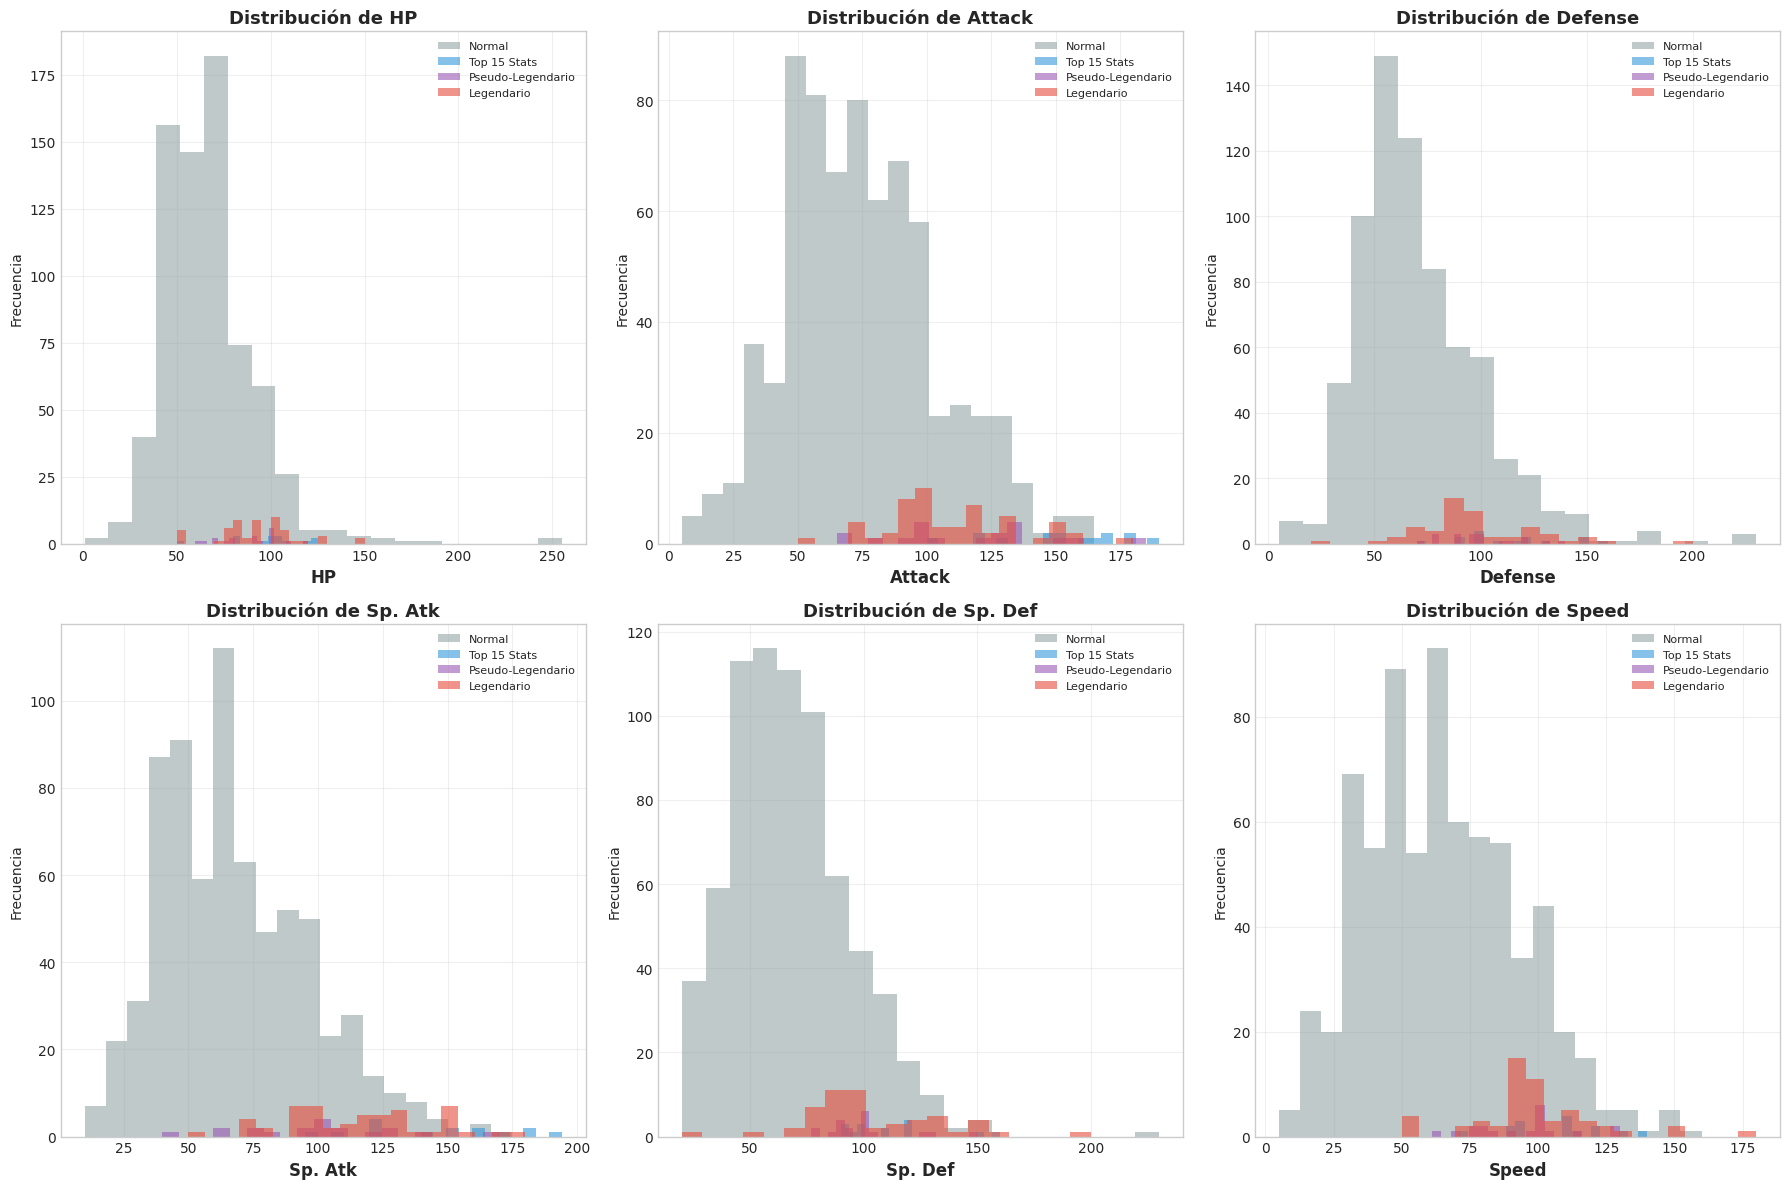

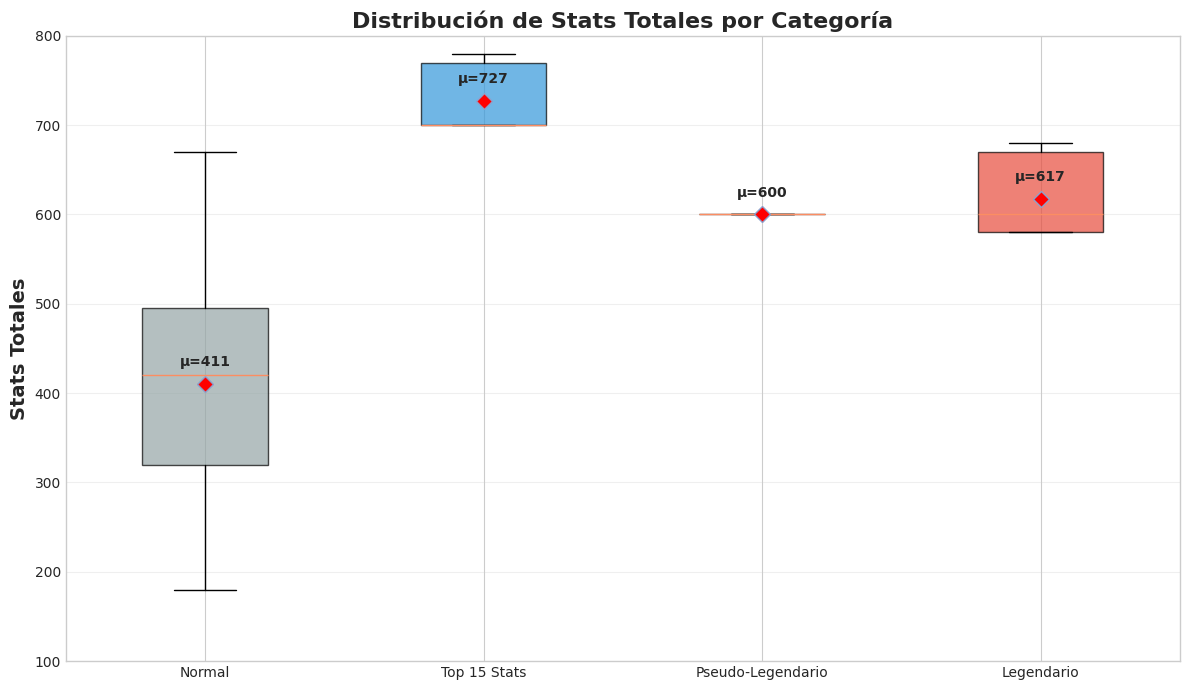

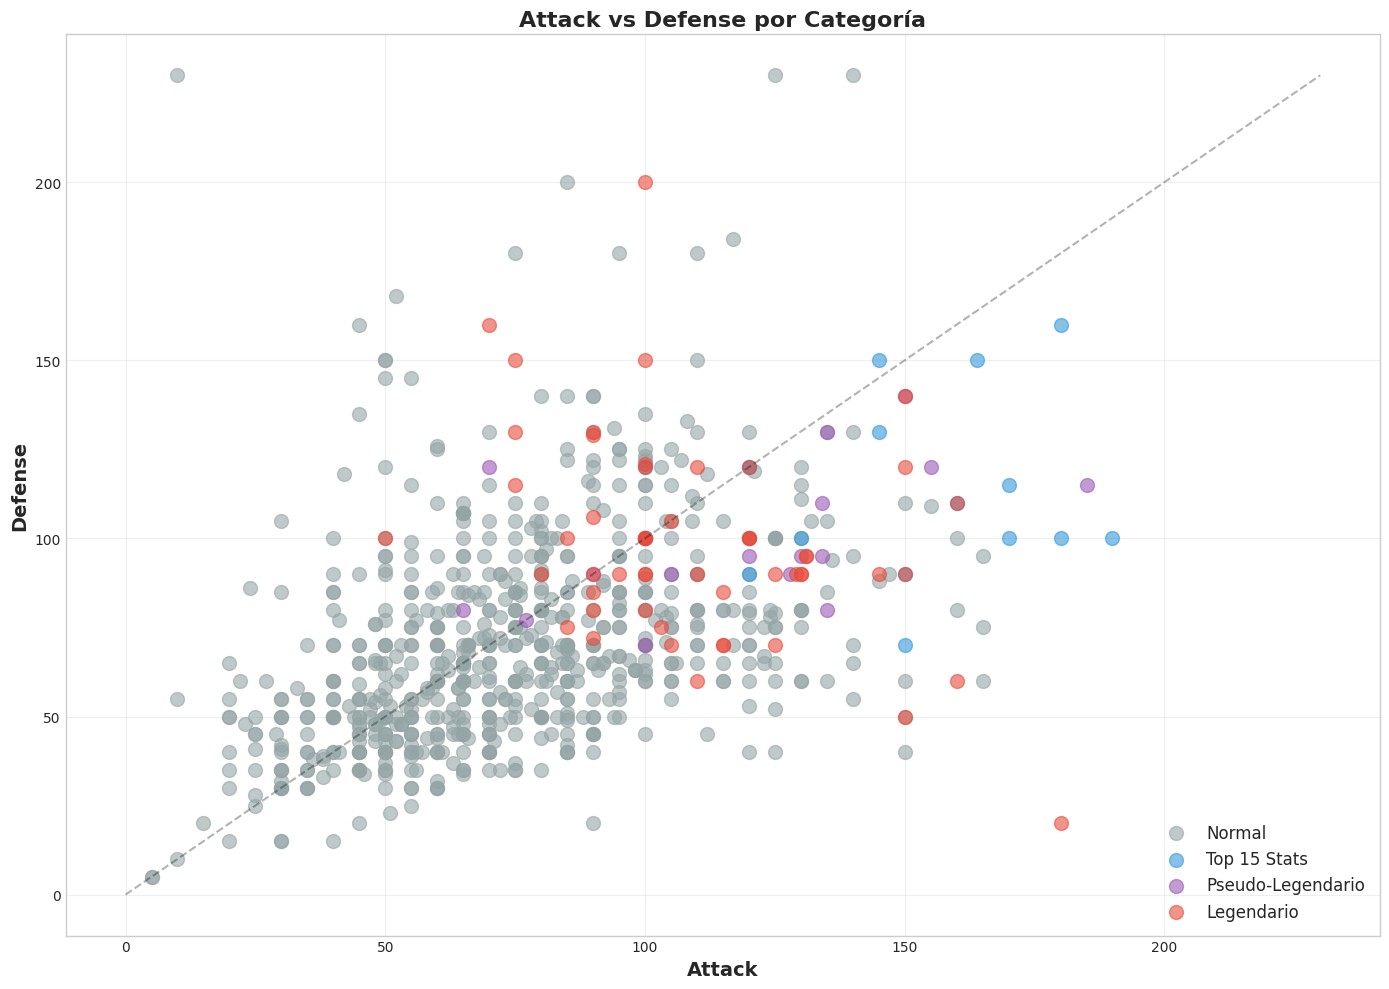

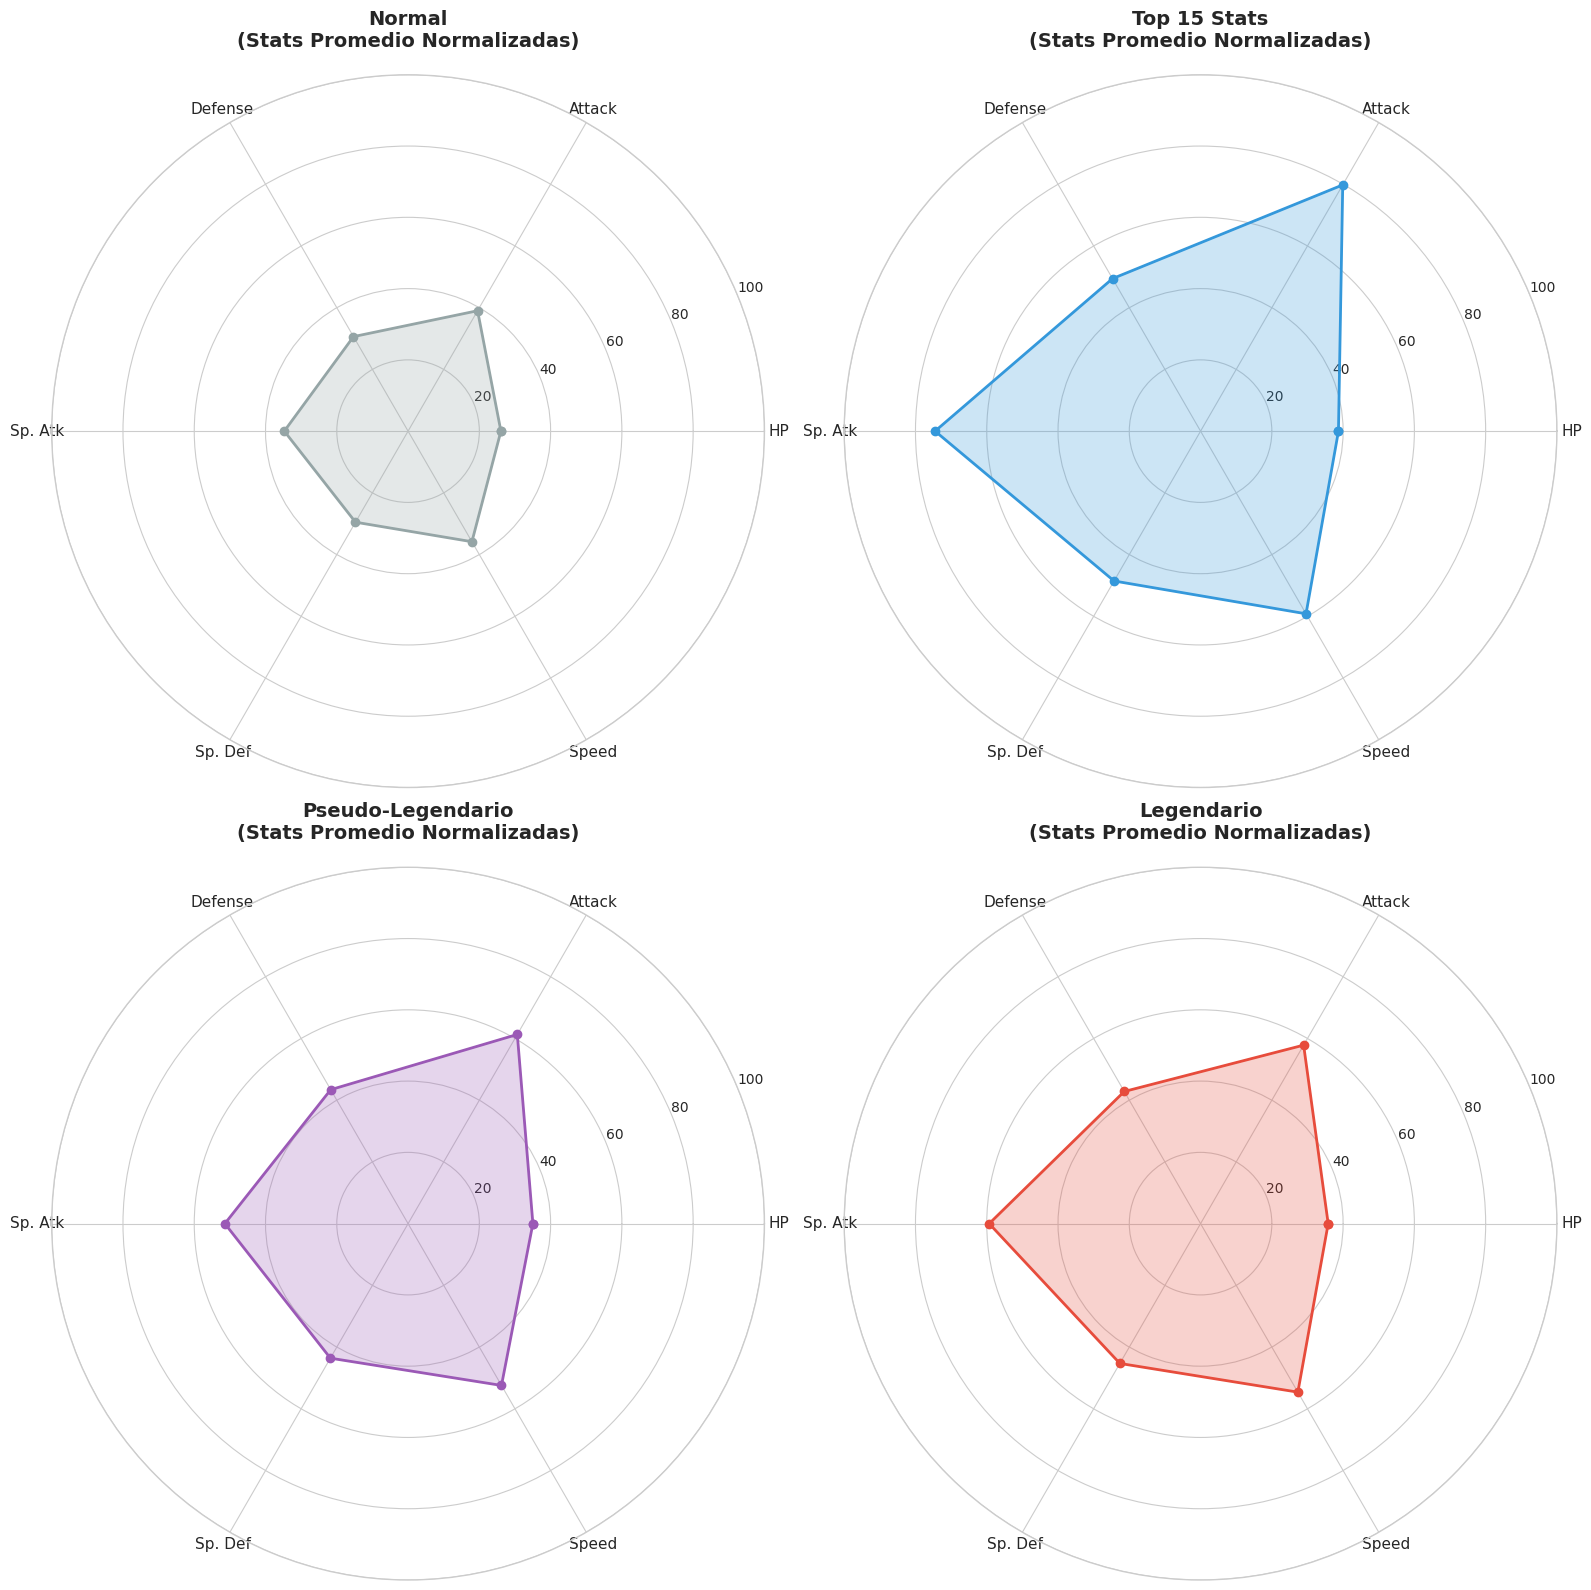

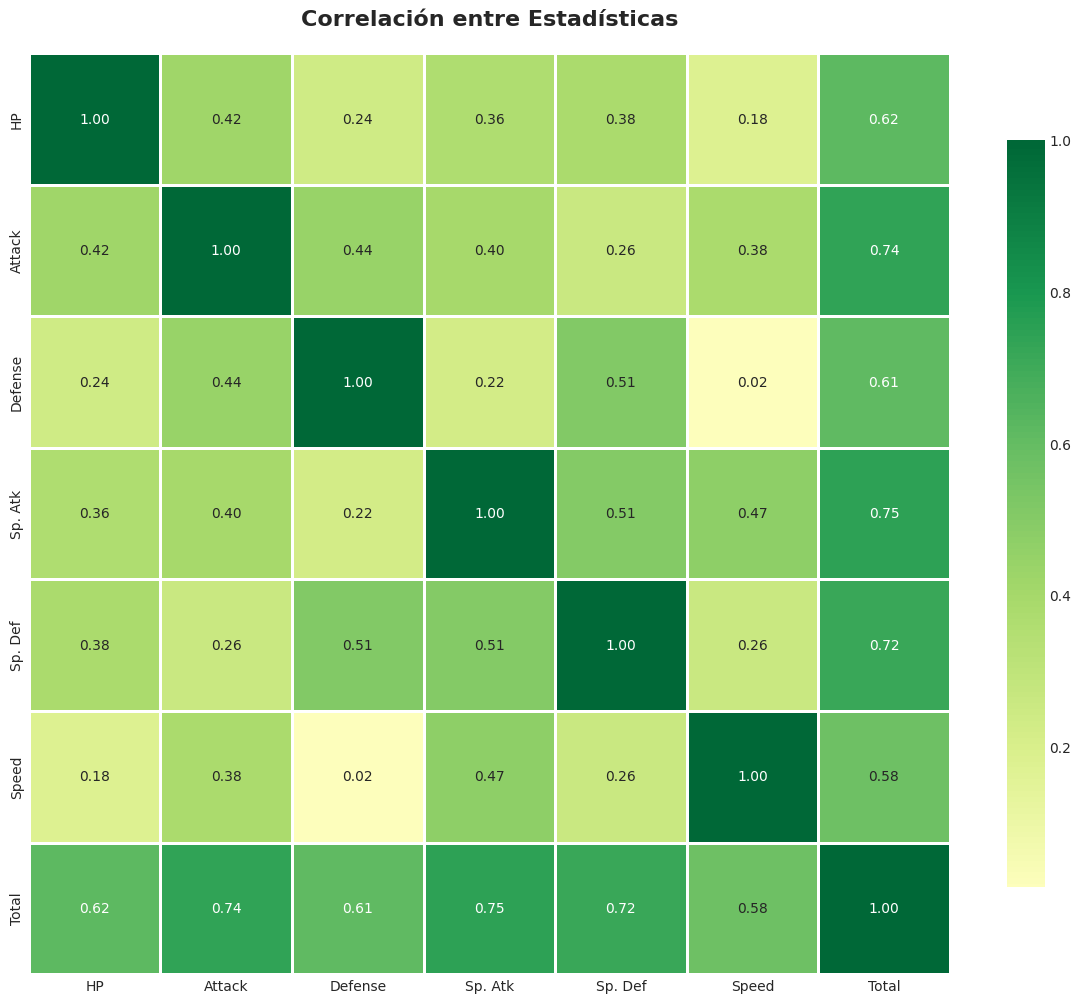

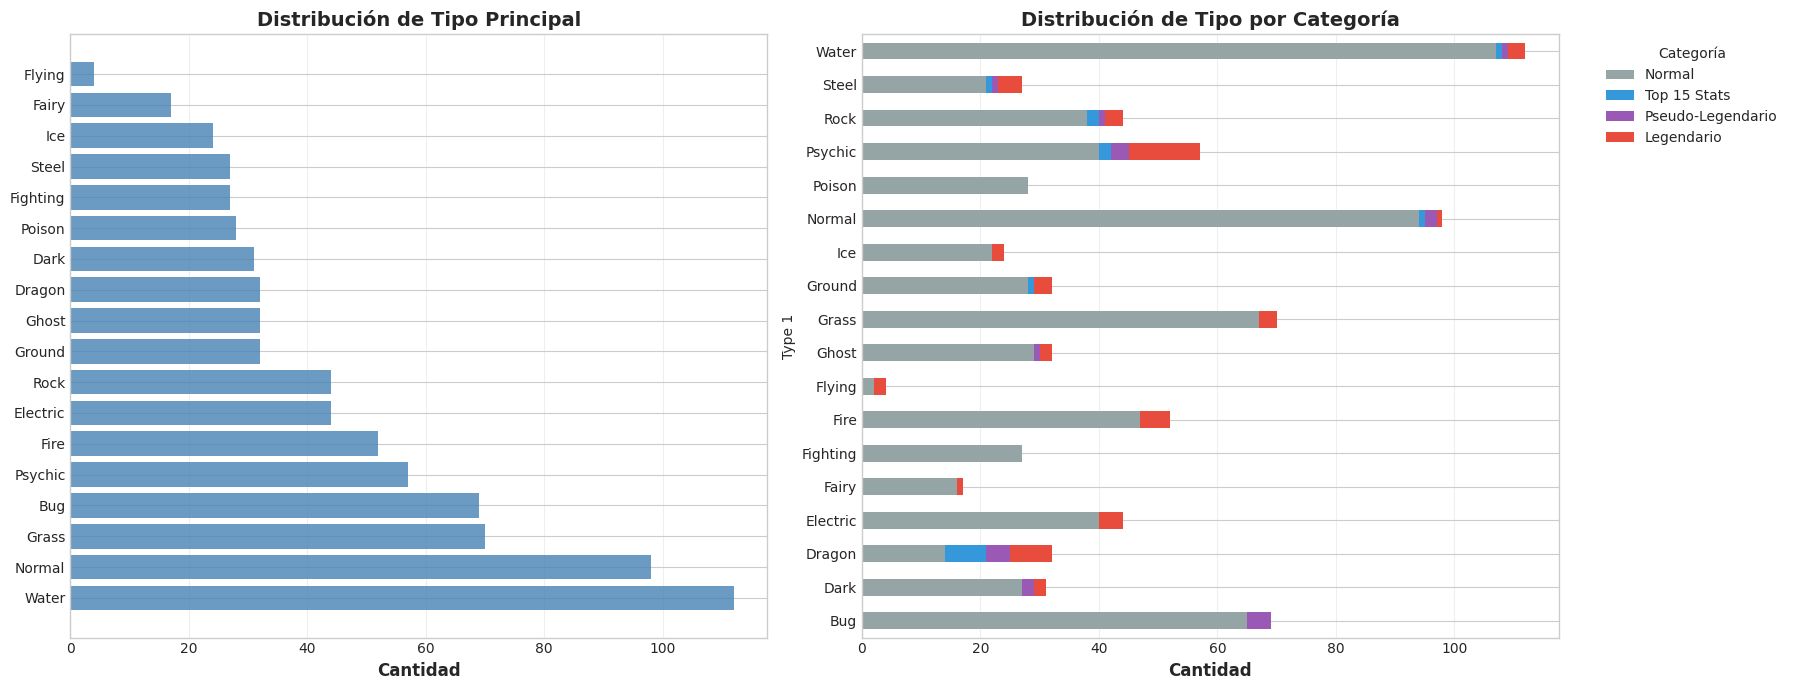

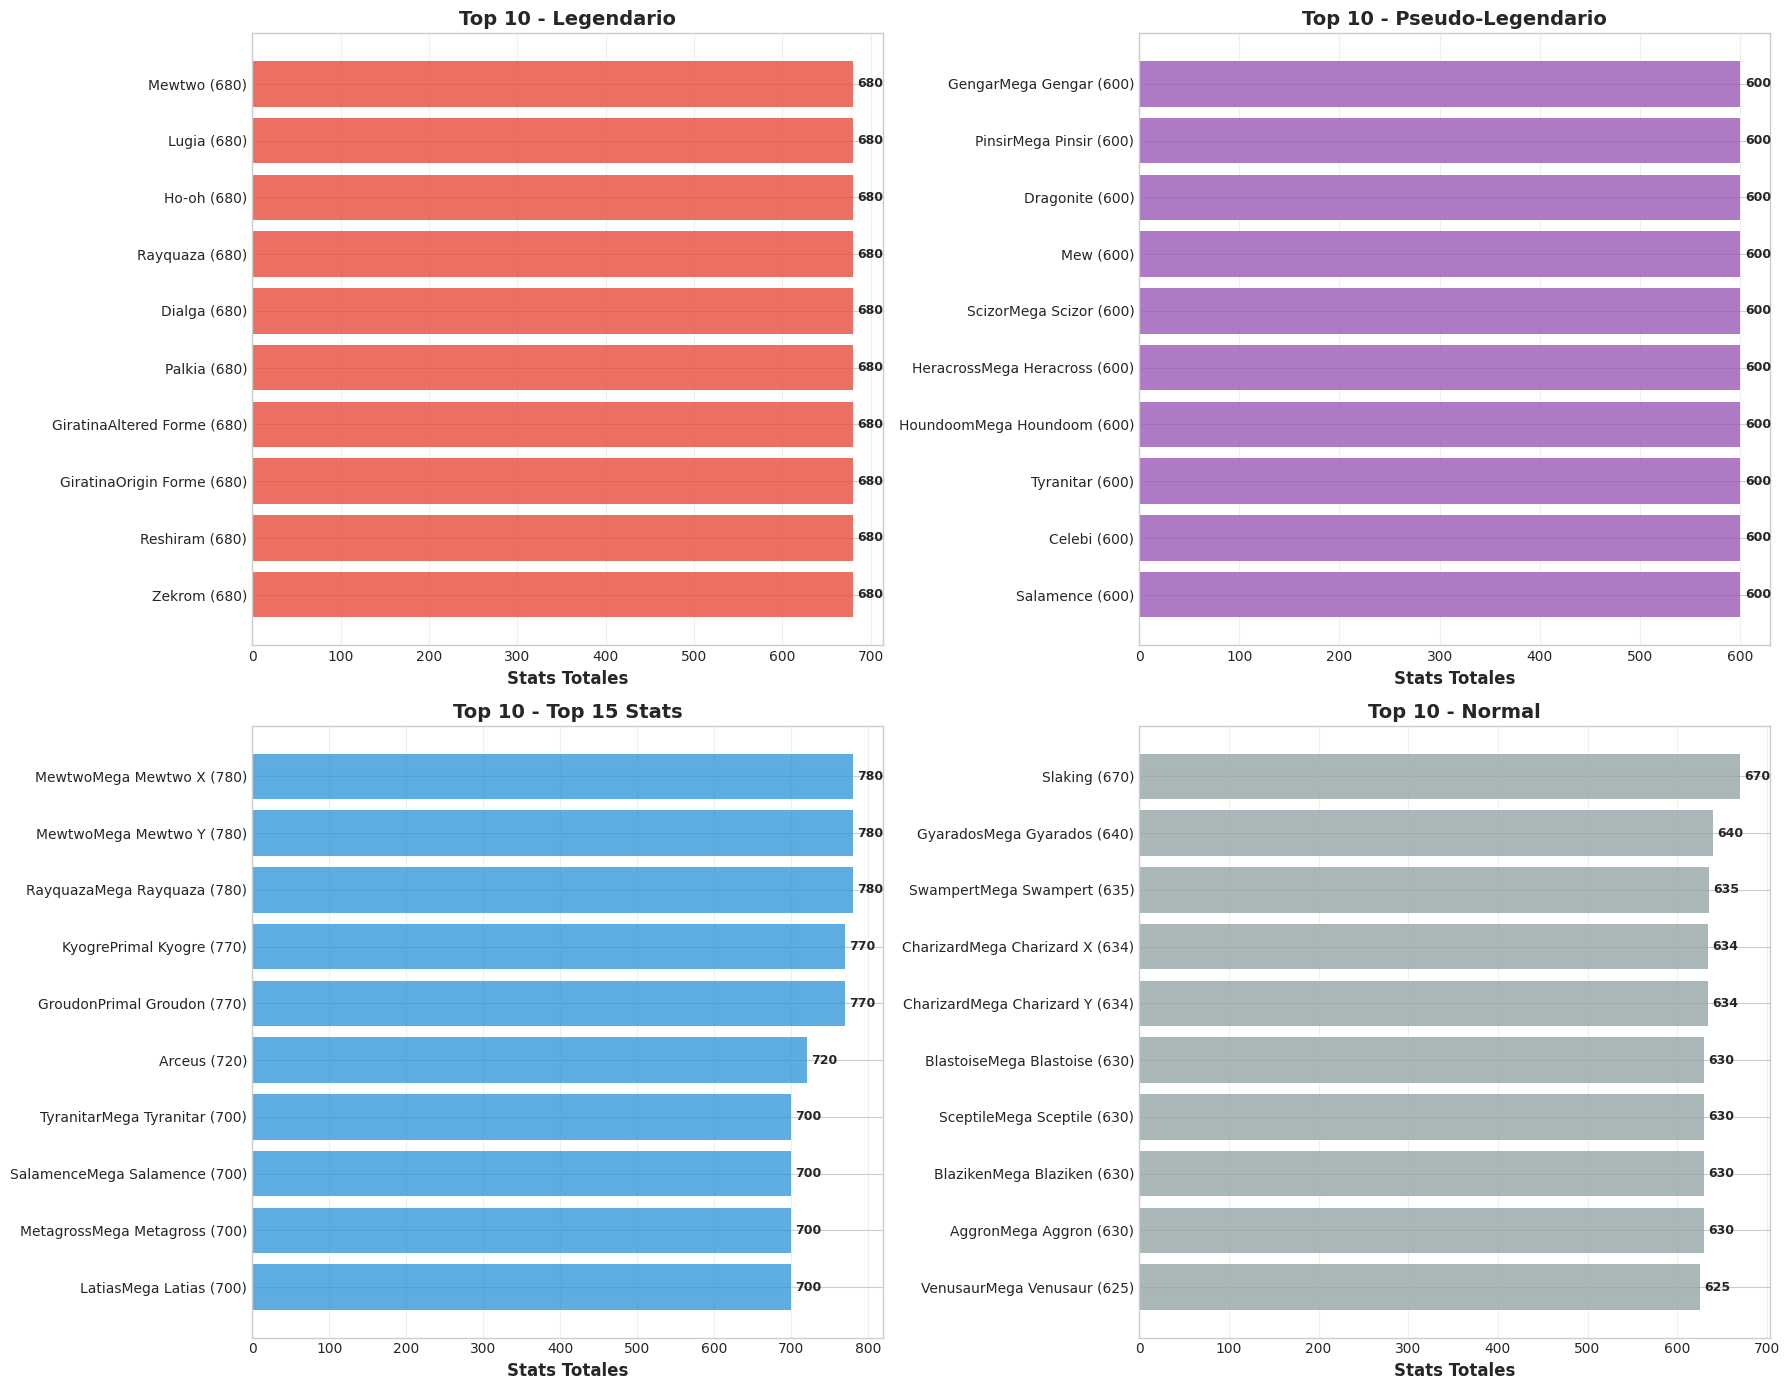

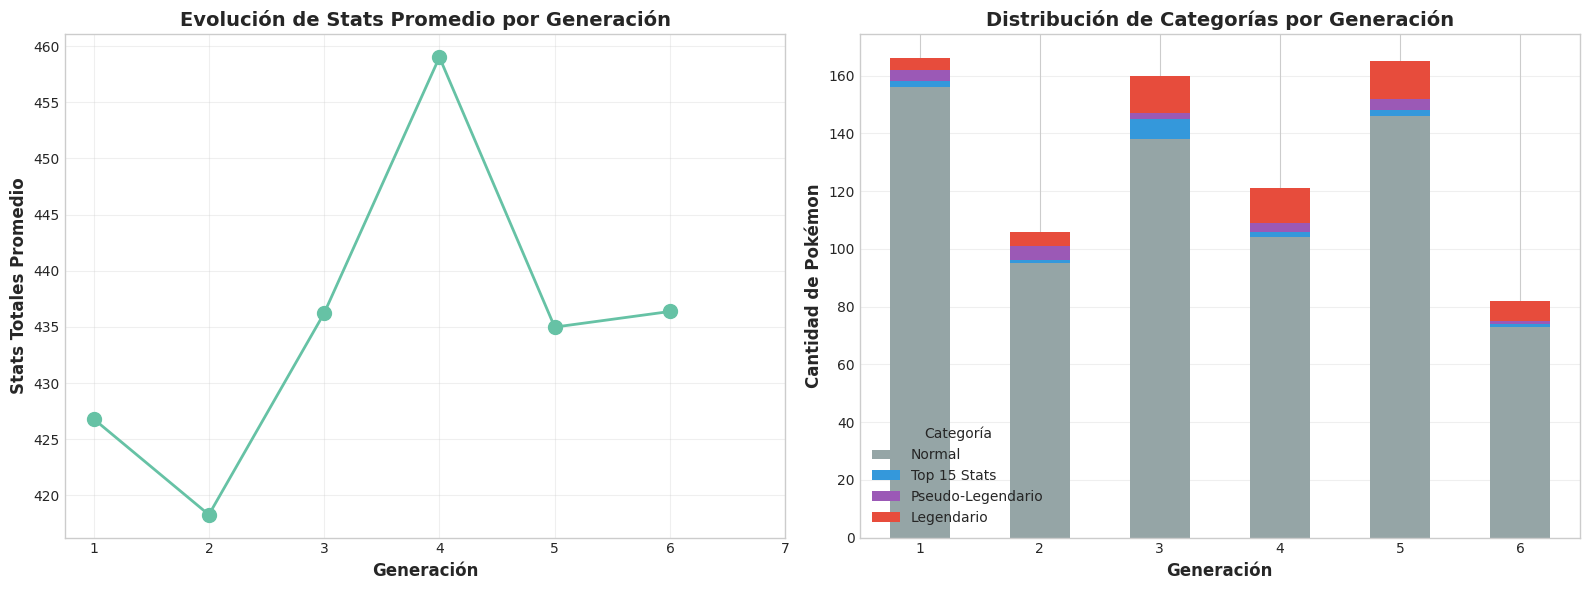

In [25]:
"""
Análisis Exploratorio y Visualizaciones del Dataset de Pokémon
Versión corregida para WSL - Rutas locales
"""

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Crear carpeta para guardar visualizaciones
OUTPUT_DIR = 'visualizations'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("ANÁLISIS EXPLORATORIO DEL DATASET DE POKÉMON")
print("="*80)

# ============================================================================
# 1. CARGAR DATOS
# ============================================================================
print("\n[1] Cargando dataset de Pokémon...")
path = kagglehub.dataset_download("abcsds/pokemon")
print(f"Dataset descargado en: {path}")

# Leer el CSV
df = pd.read_csv(f"{path}/Pokemon.csv")
print(f"Dataset cargado: {df.shape[0]} Pokémon, {df.shape[1]} columnas")

# ============================================================================
# 2. CREAR CATEGORÍAS
# ============================================================================
print("\n[2] Creando categorías de clasificación...")

# Identificar Pseudo-Legendarios
pseudo_legendary_total = 600
df['is_pseudo_legendary'] = (
    (df['Total'] == pseudo_legendary_total) & 
    (df['Legendary'] == False)
)

# Top 15 incluye a TODOS los Pokémon (sin excluir ninguna clase)
top_n = 15
top_pokemon = df.nlargest(top_n, 'Total')
df['is_top15'] = df.index.isin(top_pokemon.index)

def categorize_pokemon(row):
    if row['is_top15']:
        return 'Top 15 Stats'  # Prioridad máxima
    elif row['Legendary']:
        return 'Legendario'
    elif row['is_pseudo_legendary']:
        return 'Pseudo-Legendario'
    else:
        return 'Normal'

df['category'] = df.apply(categorize_pokemon, axis=1)

print("\nDistribución de categorías:")
print(df['category'].value_counts())

# ============================================================================
# 3. VISUALIZACIÓN 1: Distribución de Stats por Categoría
# ============================================================================
print("\n[3] Generando visualización de distribución de stats...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
stats_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
colors = {'Normal': '#95a5a6', 'Top 15 Stats': '#3498db', 
          'Pseudo-Legendario': '#9b59b6', 'Legendario': '#e74c3c'}

for idx, stat in enumerate(stats_cols):
    ax = axes[idx // 3, idx % 3]
    
    for category in ['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']:
        data = df[df['category'] == category][stat]
        ax.hist(data, alpha=0.6, label=category, bins=20, color=colors[category])
    
    ax.set_xlabel(stat, fontsize=12, fontweight='bold')
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.set_title(f'Distribución de {stat}', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/stat_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: stat_distribution.png")

# ============================================================================
# 4. VISUALIZACIÓN 2: Box Plot de Stats Totales por Categoría
# ============================================================================
print("\n[4] Generando box plots...")

fig, ax = plt.subplots(figsize=(12, 7))
category_order = ['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']
bp = ax.boxplot([df[df['category'] == cat]['Total'] for cat in category_order],
                 labels=category_order,
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Colorear boxes
for patch, category in zip(bp['boxes'], category_order):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Stats Totales', fontsize=14, fontweight='bold')
ax.set_title('Distribución de Stats Totales por Categoría', fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(100, 800)

# Añadir valores medios
for i, category in enumerate(category_order):
    mean_val = df[df['category'] == category]['Total'].mean()
    ax.text(i+1, mean_val + 20, f'μ={mean_val:.0f}', 
            ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/total_stats_boxplot.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: total_stats_boxplot.png")

# ============================================================================
# 5. VISUALIZACIÓN 3: Scatter Plot - Attack vs Defense por Categoría
# ============================================================================
print("\n[5] Generando scatter plots...")

fig, ax = plt.subplots(figsize=(14, 10))

for category in ['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']:
    data = df[df['category'] == category]
    ax.scatter(data['Attack'], data['Defense'], 
              alpha=0.6, s=100, label=category, color=colors[category])

ax.set_xlabel('Attack', fontsize=14, fontweight='bold')
ax.set_ylabel('Defense', fontsize=14, fontweight='bold')
ax.set_title('Attack vs Defense por Categoría', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# Añadir línea de balance
max_val = max(df['Attack'].max(), df['Defense'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Balance perfecto')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attack_vs_defense.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: attack_vs_defense.png")

# ============================================================================
# 6. VISUALIZACIÓN 4: Radar Chart de Stats Promedio
# ============================================================================
print("\n[6] Generando radar charts...")

categories = ['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']
stats_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for idx, category in enumerate(categories):
    ax = axes[idx]
    
    # Calcular promedios
    stats_avg = df[df['category'] == category][stats_cols].mean().values
    
    # Normalizar a escala 0-100
    stats_normalized = (stats_avg / df[stats_cols].max().values) * 100
    
    # Cerrar el polígono
    angles = np.linspace(0, 2 * np.pi, len(stats_cols), endpoint=False).tolist()
    stats_normalized = np.concatenate((stats_normalized, [stats_normalized[0]]))
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, stats_normalized, 'o-', linewidth=2, color=colors[category])
    ax.fill(angles, stats_normalized, alpha=0.25, color=colors[category])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stats_cols, fontsize=11)
    ax.set_ylim(0, 100)
    ax.set_title(f'{category}\n(Stats Promedio Normalizadas)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/radar_charts.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: radar_charts.png")

# ============================================================================
# 7. VISUALIZACIÓN 5: Heatmap de Correlaciones
# ============================================================================
print("\n[7] Generando heatmap de correlaciones...")

fig, ax = plt.subplots(figsize=(12, 10))
correlation_matrix = df[stats_cols + ['Total']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_title('Correlación entre Estadísticas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: correlation_heatmap.png")

# ============================================================================
# 8. VISUALIZACIÓN 6: Distribución por Tipo
# ============================================================================
print("\n[8] Generando distribución por tipo...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Tipo 1
type1_counts = df['Type 1'].value_counts()
ax1.barh(type1_counts.index, type1_counts.values, color='steelblue', alpha=0.8)
ax1.set_xlabel('Cantidad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Tipo Principal', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Tipo y Categoría
type_category = pd.crosstab(df['Type 1'], df['category'])
type_category = type_category[['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']]
type_category.plot(kind='barh', stacked=True, ax=ax2, 
                   color=[colors[cat] for cat in type_category.columns])
ax2.set_xlabel('Cantidad', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Tipo por Categoría', fontsize=14, fontweight='bold')
ax2.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/type_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: type_distribution.png")

# ============================================================================
# 9. VISUALIZACIÓN 7: Top Pokémon por Categoría
# ============================================================================
print("\n[9] Generando ranking de top Pokémon...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, category in enumerate(['Legendario', 'Pseudo-Legendario', 'Top 15 Stats', 'Normal']):
    ax = axes[idx]
    
    # Top 10 de cada categoría
    top_pokemon = df[df['category'] == category].nlargest(10, 'Total')
    
    # Crear labels con nombre y total
    labels = [f"{name} ({total})" 
             for name, total in zip(top_pokemon['Name'], top_pokemon['Total'])]
    
    ax.barh(range(len(top_pokemon)), top_pokemon['Total'], color=colors[category], alpha=0.8)
    ax.set_yticks(range(len(top_pokemon)))
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel('Stats Totales', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 - {category}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, v in enumerate(top_pokemon['Total'].values):
        ax.text(v + 5, i, str(v), va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/top_pokemon_ranking.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: top_pokemon_ranking.png")

# ============================================================================
# 10. ESTADÍSTICAS DESCRIPTIVAS
# ============================================================================
print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS POR CATEGORÍA")
print("="*80)

for category in ['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']:
    print(f"\n{'='*60}")
    print(f"{category.upper()}")
    print('='*60)
    
    cat_data = df[df['category'] == category]
    print(f"Cantidad: {len(cat_data)}")
    print(f"\nStats promedio:")
    print(cat_data[stats_cols + ['Total']].mean().to_string())
    print(f"\nTop 3:")
    print(cat_data.nlargest(3, 'Total')[['Name', 'Type 1', 'Total']].to_string(index=False))

# ============================================================================
# 11. ANÁLISIS DE GENERACIONES
# ============================================================================
print("\n" + "="*80)
print("ANÁLISIS POR GENERACIÓN")
print("="*80)

gen_analysis = df.groupby('Generation').agg({
    'Total': ['mean', 'max'],
    'Name': 'count',
    'Legendary': 'sum'
}).round(2)

gen_analysis.columns = ['Stats Promedio', 'Stats Máximo', 'Cantidad', 'Legendarios']
print(gen_analysis.to_string())

# Gráfico de evolución por generación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stats promedio por generación
gen_avg = df.groupby('Generation')['Total'].mean()
ax1.plot(gen_avg.index, gen_avg.values, marker='o', linewidth=2, markersize=10)
ax1.set_xlabel('Generación', fontsize=12, fontweight='bold')
ax1.set_ylabel('Stats Totales Promedio', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de Stats Promedio por Generación', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xticks(range(1, 8))

# Cantidad por categoría y generación
gen_cat = pd.crosstab(df['Generation'], df['category'])
gen_cat = gen_cat[['Normal', 'Top 15 Stats', 'Pseudo-Legendario', 'Legendario']]
gen_cat.plot(kind='bar', stacked=True, ax=ax2, 
            color=[colors[cat] for cat in gen_cat.columns])
ax2.set_xlabel('Generación', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cantidad de Pokémon', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Categorías por Generación', fontsize=14, fontweight='bold')
ax2.legend(title='Categoría')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/generation_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Guardado: generation_analysis.png")

# ============================================================================
# 12. RESUMEN FINAL
# ============================================================================
print("\n" + "="*80)
print("RESUMEN DEL ANÁLISIS")
print("="*80)

print(f"\n📊 Total de Pokémon analizados: {len(df)}")
print(f"📈 Rango de Stats Totales: {df['Total'].min()} - {df['Total'].max()}")
print(f"📉 Stats Totales Promedio: {df['Total'].mean():.2f}")
print(f"🌟 Pokémon Legendarios: {df['Legendary'].sum()} ({df['Legendary'].sum()/len(df)*100:.1f}%)")
print(f"💎 Pseudo-Legendarios: {df['is_pseudo_legendary'].sum()}")
print(f"🏆 Top 15 Stats: {df['is_top15'].sum()}")
print(f"⚪ Pokémon Normales: {len(df[df['category'] == 'Normal'])}")

print(f"\n🎮 Generaciones: {df['Generation'].min()} - {df['Generation'].max()}")
print(f"🎨 Tipos únicos: {df['Type 1'].nunique()}")

print("\n" + "="*80)
print("VISUALIZACIONES GUARDADAS EN LA CARPETA 'visualizations/'")
print("="*80)
print("""
✓ stat_distribution.png       - Histogramas de distribución de stats
✓ total_stats_boxplot.png     - Box plots de stats totales
✓ attack_vs_defense.png        - Scatter plot Attack vs Defense
✓ radar_charts.png             - Radar charts por categoría
✓ correlation_heatmap.png      - Mapa de calor de correlaciones
✓ type_distribution.png        - Distribución por tipo
✓ top_pokemon_ranking.png      - Top 10 Pokémon por categoría
✓ generation_analysis.png      - Análisis por generación
""")

print(f"\nTodas las visualizaciones han sido guardadas en: ./{OUTPUT_DIR}/")
print("="*80)